## 1. View Saharan dust transport across Atlantic in July 2020

In [1]:
ADS_URL = "https://ads.atmosphere.copernicus.eu/api/v2"

ADS_KEY = "8089:4c1cd739-4ef0-43c2-be7f-3120e8d7c96f"

In [2]:
## install api to allow data download
!pip install cdsapi

In [35]:
## Import libries

# CDS API
import cdsapi

# For working with multidimensional array
import numpy as np
import xarray as xr
# ref: http://xarray.pydata.org/en/stable/getting-started-guide/installing.html


# For plotting and visualising data
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import animation, rc  # animation

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature


# Others  ??
from zipfile import ZipFile   
from IPython.display import clear_output  
from time import sleep  


## CAMS global atmospheric composition data

In [32]:
import cdsapi

c = cdsapi.Client(url = ADS_URL, key = ADS_KEY)

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'date': '2021-07-01/2021-07-31',
        'type': 'forecast',
        'format': 'netcdf_zip',
        'variable': 'dust_aerosol_optical_depth_550nm',
        'time': [
            '00:00', '12:00',
        ],
        'leadtime_hour': '0',
        'area': [
            90, -180, -90,
            90,
        ],
    },
    'download.netcdf_zip')

/Users/xchen/opt/miniconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-12-07 15:35:42,172 INFO Welcome to the CDS
2021-12-07 15:35:42,172 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
/Users/xchen/opt/miniconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-12-07 15:35:42,202 INFO Request is queued
/Users/xchen/opt/miniconda3/lib/python3.9/site-packages/urllib3/connectionpoo

Result(content_length=37810604,content_type=application/zip,location=https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data4/adaptor.mars_constrained.external-1638891356.475842-8079-1-8a0e177e-c2aa-403e-ab8b-8db6727233a4.zip)

## Read Data
- data in NetCDF format, a commonly used format for gridded (array-based) scientific data
- make use of the Xarray library
- Xarray makes working with labelled multi-dimensional arrays simple and efficient
- read the data from our NetCDF file into an Xarray "dataset"

In [33]:
# Creat a ZipFile Object and load zip file in it

with ZipFile(f'./DU_JUL_SAHARA.zip', 'r') as zipObj:
    zipObj.extractall(path = f'./DU_JUL_SAHARA/')
    

In [34]:
# rename the file data.nc in the data
fn = f'./DU_JUL_SAHARA/data.nc'


In [36]:
# read the data into Xarray dataset
ds = xr.open_dataset(fn)

In [37]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 676, latitude: 451, time: 62)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 89.2 89.6 90.0
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-07-01 ... 2021-07-31T12:00:00
Data variables:
    duaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-07 15:35:56 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [38]:
da = ds['duaod550']

In [39]:
da

<xarray.DataArray 'duaod550' (time: 62, latitude: 451, longitude: 676)>
[18902312 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 89.2 89.6 90.0
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-07-01 ... 2021-07-31T12:00:00
Attributes:
    units:      ~
    long_name:  Dust Aerosol Optical Depth at 550nm

## Visualize one time step

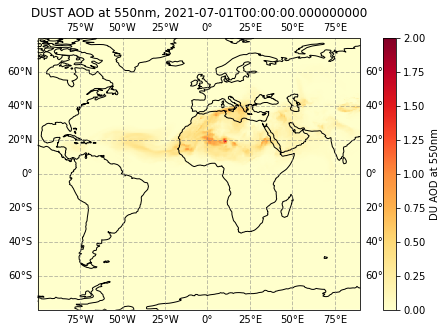

In [40]:
time_step = 0

# create the fig pannel
fig = plt.figure(figsize = (10, 5))


# use cartopy PlateCarree projection
ax = plt.subplot(1, 1, 1, projection = ccrs.PlateCarree())
ax = plt.subplot(1, 1, 1, projection = ccrs.Orthographic())


# specify geographical extent
#ax.set_extent([-100, 90, -80, 80], crs = ccrs.PlateCarree())
#ax.set_extent([-150, -50, 25, 80], crs = ccrs.Mollweide())


# add lat/lon grid
ax.gridlines(draw_labels = True, linewidth = 1, color = "gray",
            alpha = 0.5, linestyle = "--")

# set the fig title
ax.set_title(f'DUST AOD at 550nm, {da.time[time_step].values}',
            fontsize = 12)

# plot the data
im = plt.pcolormesh(da.longitude, da.latitude, da[time_step, :, :], 
              cmap = "YlOrRd", vmin = 0, vmax = 2)

# add coastlines
ax.coastlines(color = 'black')

# Specify the colourbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04) 

# Define the colourbar label
cbar.set_label('DU AOD at 550nm')


## Visualize animation 

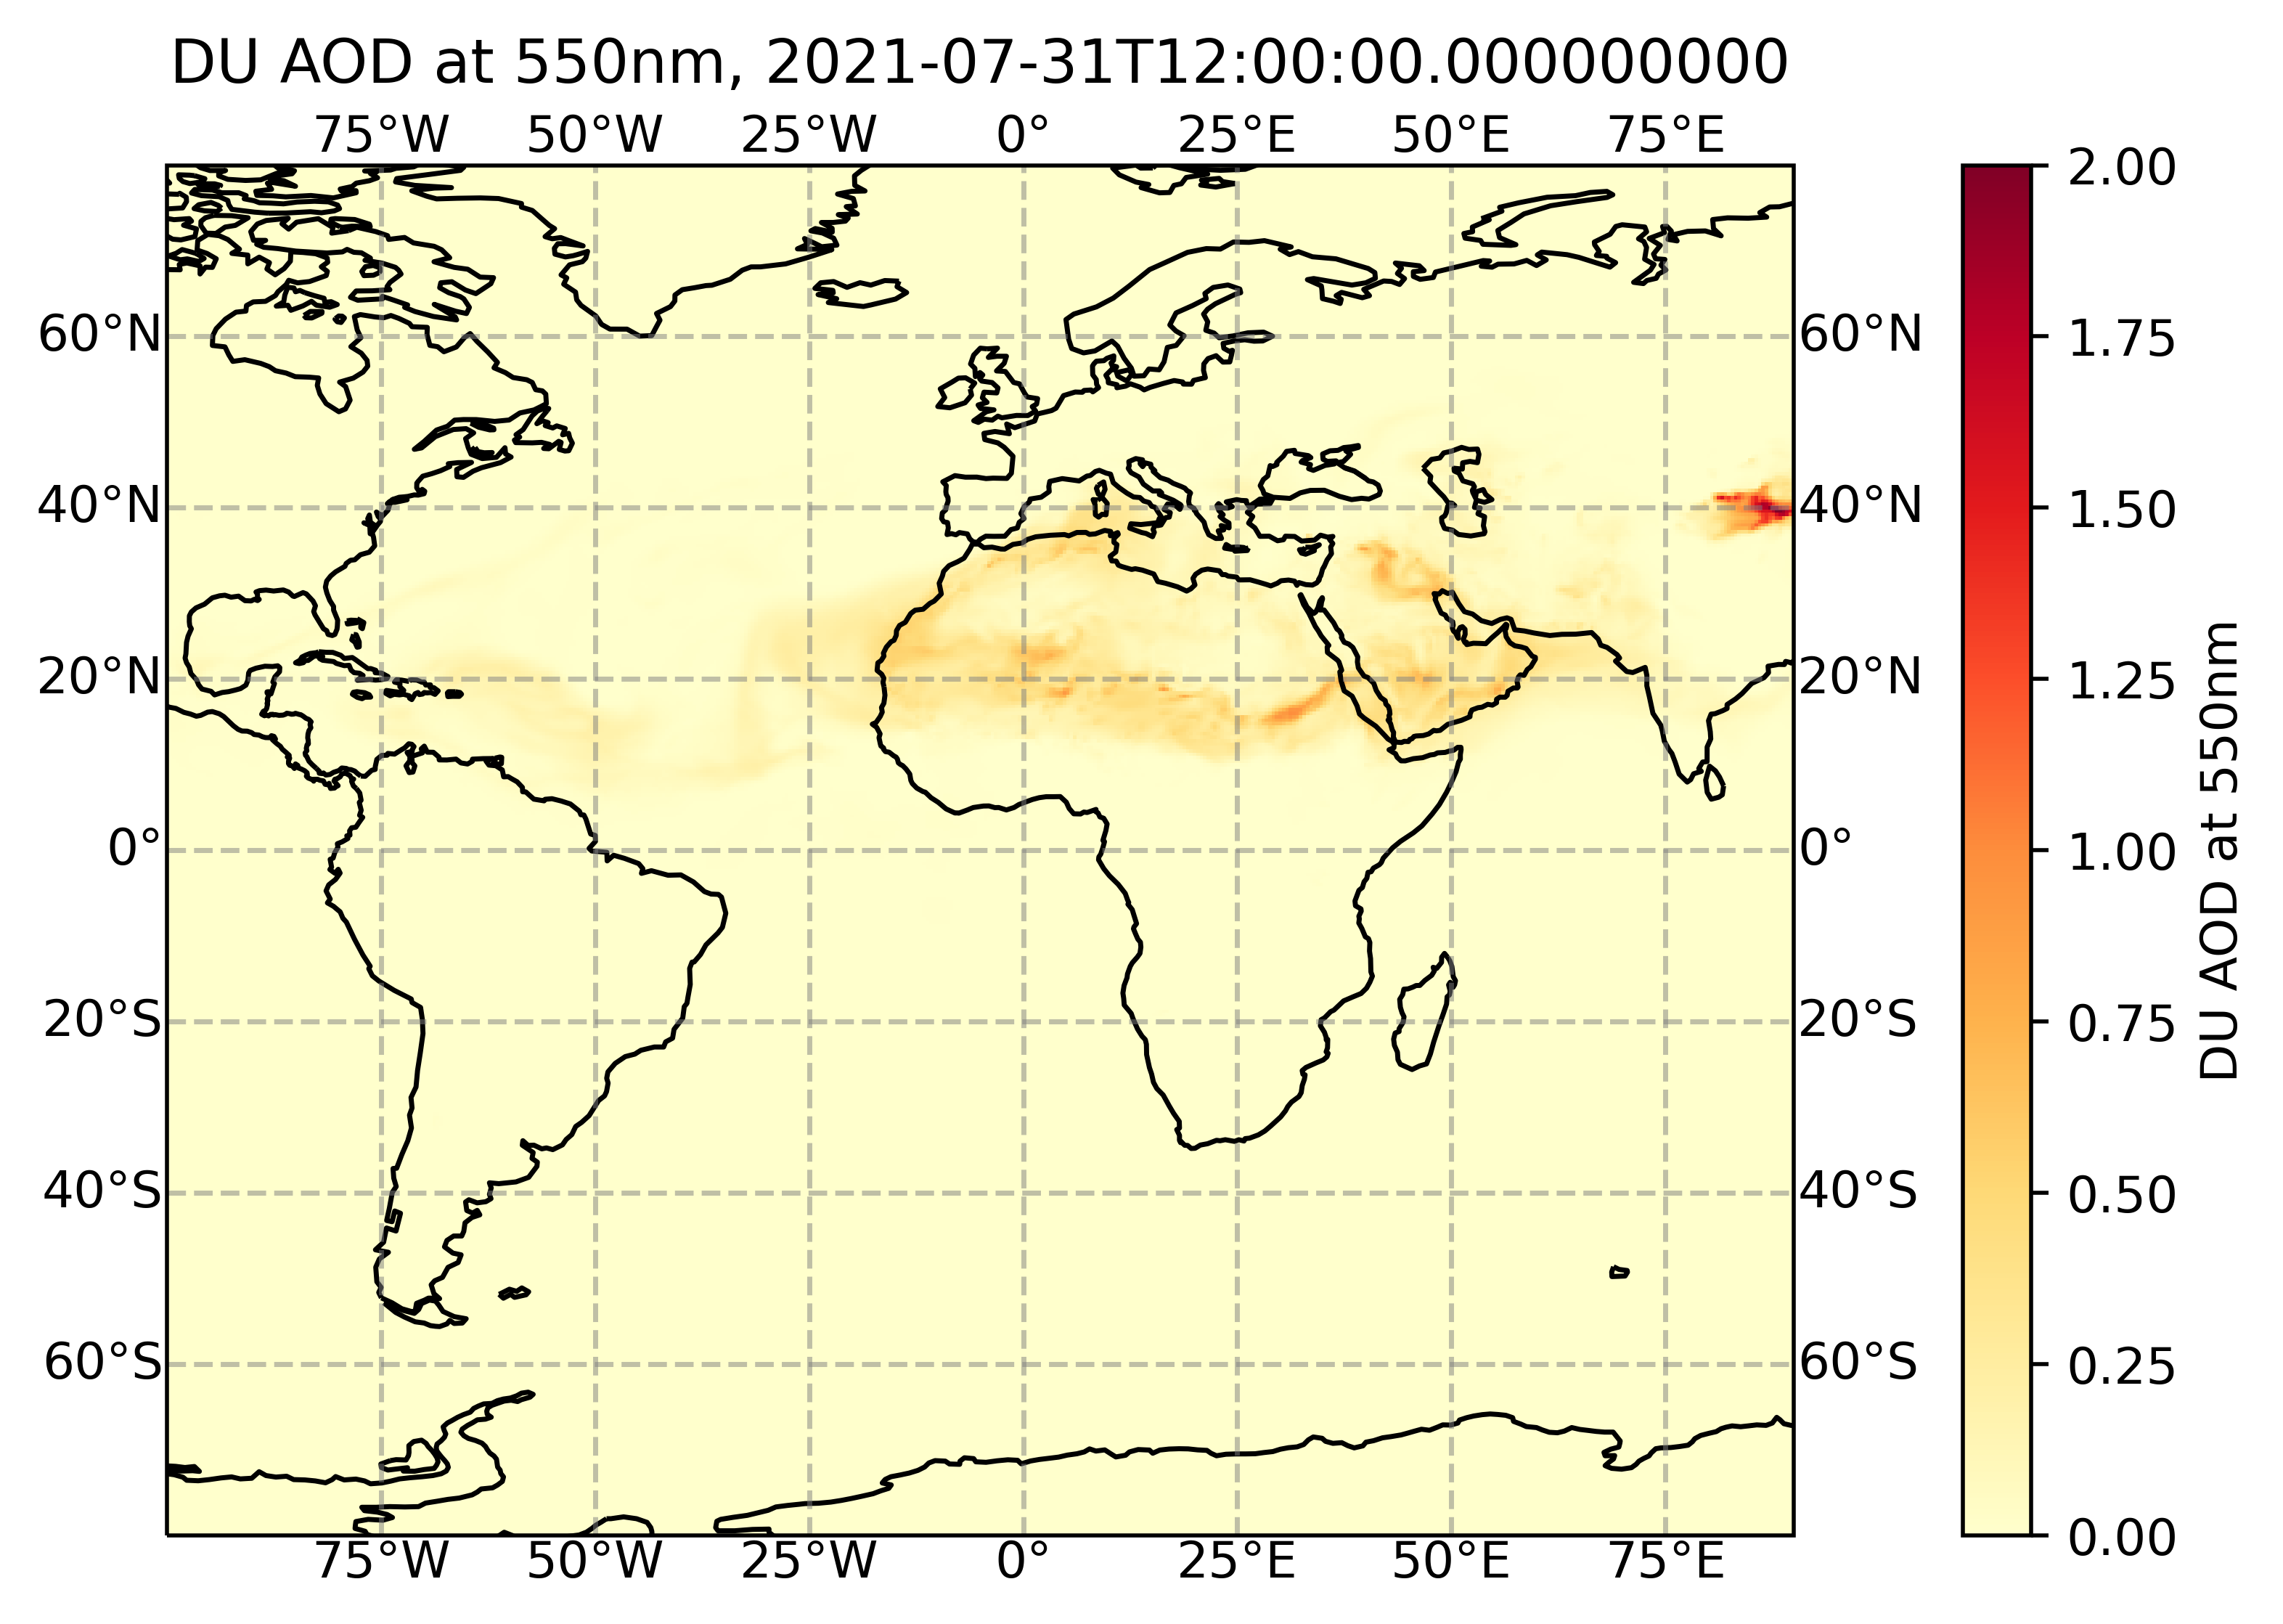

In [49]:
n = da.time.shape[0] # 62

for i in range(n):
    fig = plt.figure(figsize = (10, 5), dpi = 500)
    ax = plt.subplot(1, 1, 1, projection = ccrs.PlateCarree())
    ax.set_extent([-100, 90, -80, 80], crs = ccrs.PlateCarree())
    ax.gridlines(draw_labels = True, color = 'grey', alpha = 0.5, linestyle = "--", linewidth = 1)
    ax.set_title(f'DU AOD at 550nm, {da.time[i].values}', fontsize = 12)
    im = plt.pcolormesh(da.longitude, da.latitude, da[i, :, :], cmap = 'YlOrRd', vmin = 0, vmax = 2)
    ax.coastlines(color = 'black')
    cbar = plt.colorbar(im, fraction = 0.046, pad = 0.06)
    cbar.set_label("DU AOD at 550nm")
    plt.show()
    sleep(0.01)
    clear_output(wait = True)
    #fig.savefig('./Dust_aerosol_optdepth_550nm_2020-07-01_map'+str(i)+'.png')
    fig.savefig('./DU_JUL_SAHARA/DU_AOD_550_Jul_2021_' + str(i) + '.png')

     

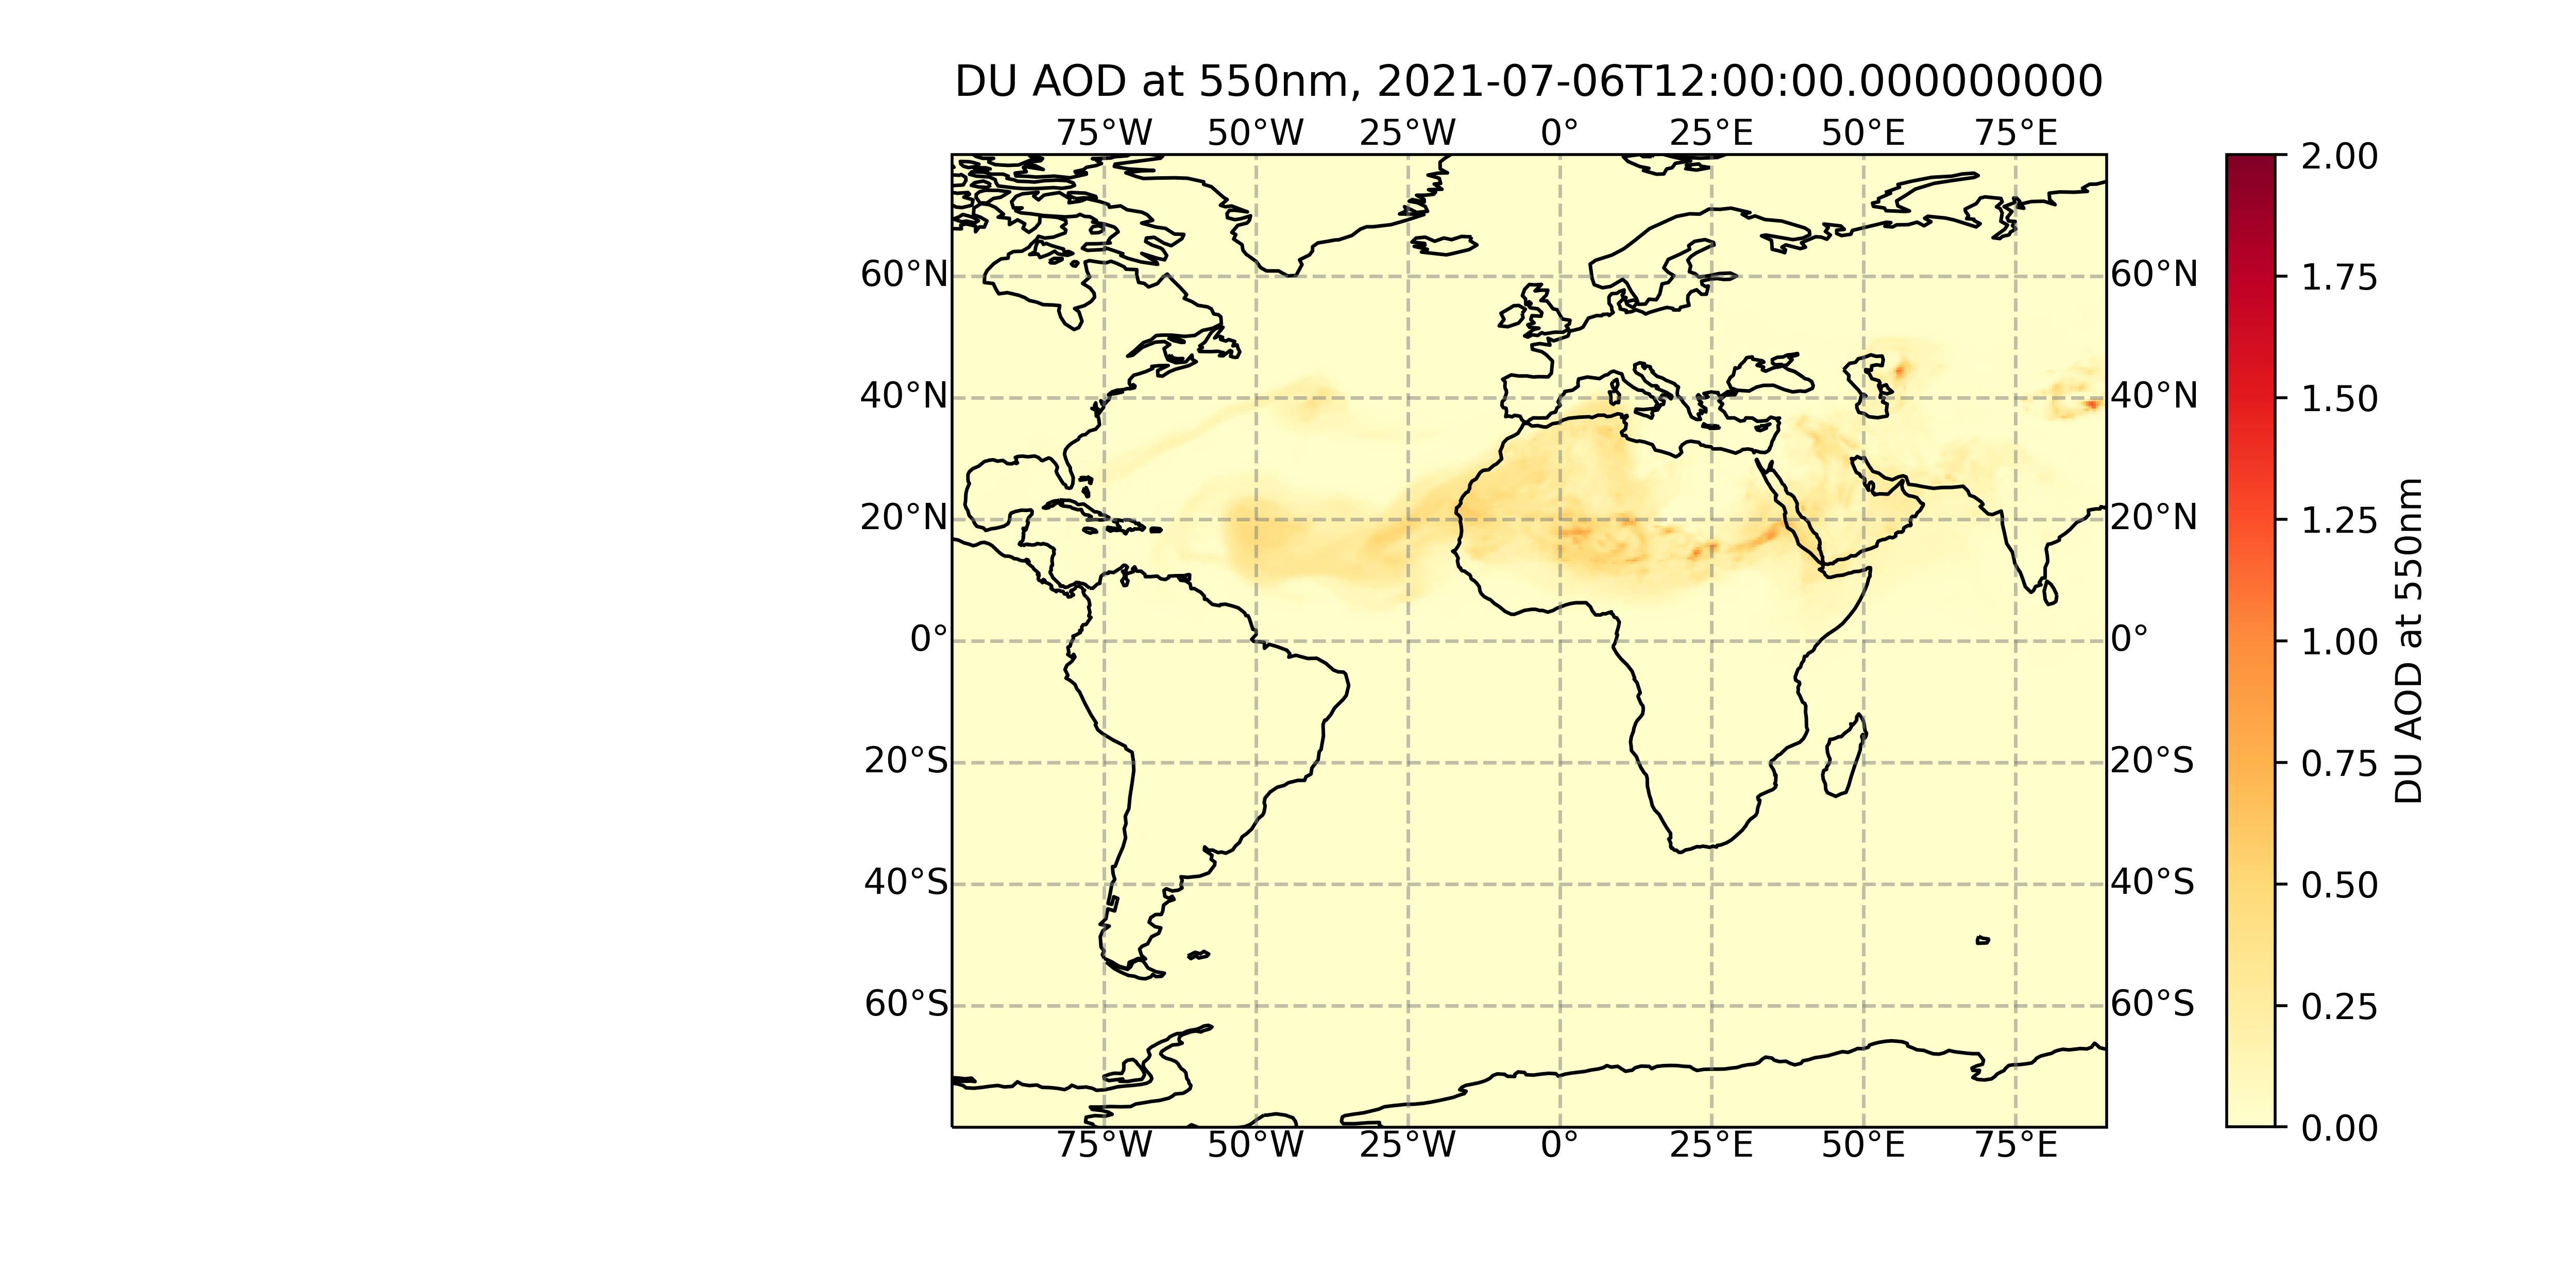

In [62]:
from PIL import Image
import glob

# Create frames
frames = []
path = r'./DU_JUL_SAHARA/'
imgs = glob.glob(path + "*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
    
frames[0]


In [63]:
frames[0].save("./DU_JUL_SAHARA/SAHARA_DU_Transport_animation.gif", format = "GIF",
               append_images = frames[1:],
               save_all = True, duration = 300,loop = 0)



In [ ]:
    
frames[0].save("SAHARA_DU_Transport_animation.gif", format = "GIF",
               append_images = frames[1:],
               save_all = True, duration = 300,loop = 0)


In [54]:
from PIL import Image
import glob
# Create the frames
frames = []
path = r'./DU_JUL_SAHARA/' #the path of the folder with the saved images
imgs = glob.glob(path + "**/*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
# Save into a GIF file that loops forever
frames[0].save('Saharan_Dust_transport_animation.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300,loop=0)


NameError: name 'new_frame' is not defined

In [ ]:
n = da.time.shape[0] # Number of frames in animation (= number of time-steps)


for i in range(n):
        fig = plt.figure(figsize = (10, 5), dpi = 500)
        ax = plt.subplot(1, 1, 1, projection = ccrs.PlateCarree())
        ax.set_extent([-150, -50, 25, 80], crs = ccrs.PlateCarree())
        ax.gridlines(draw_labels = True, color = 'gray', alpha = 0.5, linestyle = "--",
                    linewidth = 1)
        ax.set_title(f'Total OM AOD at 550nm, {da.time[i].values}', fontsize = 12) 
        #im = plt.pcolormesh(da.longitude, da.latitude, da[i, :, :], cmap = 'YlOrRd', vmin = 0, vmax = 2)   
        im = plt.pcolormesh(da.longitude, da.latitude, da[i, :, :], cmap = 'RdBu_r', vmin = 0, vmax = 2)   
        ax.coastlines(color = "black")
        cbar = plt.colorbar(im, fraction = 0.046, pad = 0.06)
        cbar.set_label("AOD at 550nm")
        plt.show()
        sleep(0.001) 
        clear_output(wait = True)
        # Clear the output (figure) before the next iteration (frame) of the animation

    